In [167]:
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

# heatmap
import math
from scipy.stats import multivariate_normal

# animation
from matplotlib.animation import FuncAnimation

In [53]:
# train.csv file
df = pd.read_csv(f"../data/train.csv")
df["path"] = df["path"].apply(lambda row: f"../data/{row}")
df.head()

,path,participant_id,sequence_id,sign
0,../data/train_landmark_files/26734/1000035562....,26734,1000035562,blow
1,../data/train_landmark_files/28656/1000106739....,28656,1000106739,wait
2,../data/train_landmark_files/16069/100015657.p...,16069,100015657,cloud
3,../data/train_landmark_files/25571/1000210073....,25571,1000210073,bird
4,../data/train_landmark_files/62590/1000240708....,62590,1000240708,owie


In [54]:
NUM_JOINTS = 543

LIP = [
    61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]

RIGHT_EYE = [
    246, 161, 160, 159, 158, 157, 173,
    33, 7, 163, 144, 145, 153, 154, 155, 133,
    247, 30, 29, 27, 28, 56, 190,
    130, 25, 110, 24, 23, 22, 26, 112, 243,
    113, 225, 224, 223, 222, 221, 189,
    226, 31, 228, 229, 230, 231, 232, 233, 244,
    143, 111, 117, 118, 119, 120, 121, 128, 245,
]

LEFT_EYE = [
    466, 387, 386, 385, 384, 398,
    263, 249, 390, 373, 374, 380, 381, 382, 362,
    467, 260, 259, 257, 258, 286, 414,
    359, 255, 339, 254, 253, 252, 256, 341, 463,
    342, 445, 444, 443, 442, 441, 413,
    446, 261, 448, 449, 450, 451, 452, 453, 464,
    372, 340, 346, 347, 348, 349, 350, 357, 465,
]

LEFT_HAND = [
    468, 469, 470, 471, 472, 473, 474, 475,
    476, 477, 478, 479, 480, 481, 482, 483,
    484, 485, 486, 487, 488
]

RIGHT_HAND = [
    522, 523, 524, 525, 526, 527, 528, 529,
    530, 531, 532, 533, 534, 535, 536, 537,
    538, 539, 540, 541, 542
]

In [210]:
idx = 10

landmark_df = pd.read_parquet(df.loc[idx].path)
landmark_df

,frame,row_id,type,landmark_index,x,y,z
0,14,14-face-0,face,0,0.474141,0.416354,-0.042849
1,14,14-face-1,face,1,0.463600,0.378343,-0.063832
2,14,14-face-2,face,2,0.469422,0.390992,-0.038287
3,14,14-face-3,face,3,0.453660,0.347890,-0.039314
4,14,14-face-4,face,4,0.462249,0.367778,-0.065897
...,...,...,...,...,...,...,...
17914,46,46-right_hand-16,right_hand,16,0.404107,0.775863,-0.026729
17915,46,46-right_hand-17,right_hand,17,0.358344,0.813799,-0.073121
17916,46,46-right_hand-18,right_hand,18,0.437495,0.813937,-0.067007
17917,46,46-right_hand-19,right_hand,19,0.416058,0.808676,-0.041302


In [211]:
print("Number of frames: ", int(len(landmark_df)/NUM_JOINTS))

Number of frames:  33


In [57]:
f_0 = landmark_df.loc[landmark_df.frame == 20]
f_0.head()

,frame,row_id,type,landmark_index,x,y,z
0,20,20-face-0,face,0,0.494400,0.380470,-0.030626
1,20,20-face-1,face,1,0.496017,0.350735,-0.057565
2,20,20-face-2,face,2,0.500818,0.359343,-0.030283
3,20,20-face-3,face,3,0.489788,0.321780,-0.040622
4,20,20-face-4,face,4,0.495304,0.341821,-0.061152


In [59]:
set(f_0.type.values)

{'face', 'left_hand', 'pose', 'right_hand'}

In [153]:
f0_face = f_0.loc[f_0.type == "face"][["x", "y", "z"]].values
f0_pose = f_0.loc[f_0.type == "pose"][["x", "y", "z"]].values[:-8]
f0_rh = f_0.loc[f_0.type == "right_hand"][["x", "y", "z"]].values
f0_lh = f_0.loc[f_0.type == "left_hand"][["x", "y", "z"]].values

In [206]:
def points_to_gaussian_heatmap(centers, height, width, scale):
    gaussians = []
    for x,y in centers:
        s = np.eye(2)*scale
        
        if not (np.isnan(x) and np.isnan(y)):
            # unnormalize centers
            x = min(math.floor(x * width), width - 1)
            y = min(math.floor(y * height), height - 1)

            g = multivariate_normal(mean=(x,y), cov=s)
            gaussians.append(g)

    # create a grid of (x,y) coordinates at which to evaluate the kernels
    x = np.arange(0, width)
    y = np.arange(0, height)
    xx, yy = np.meshgrid(x,y)
    xxyy = np.stack([xx.ravel(), yy.ravel()]).T
    
    # evaluate kernels at grid points
    zz = sum(g.pdf(xxyy) for g in gaussians)
    
    if len(gaussians) !=0:
        img = zz.reshape((height,width))
    else:
        img = np.zeros(shape=(height, width))

    return img

W = 128  # width of heatmap
H = 128  # height of heatmap
SCALE = 0.8  # increase scale to make larger gaussians

In [212]:
frames = landmark_df.frame.unique()

# faces, poses, rhs, lhs = [],[],[],[]
humans = []

for frame in tqdm(frames):
    # Get the frame and associated parts
    f = landmark_df.loc[landmark_df.frame == frame]
    face = f.loc[f.type == "face"][["x", "y", "z"]].values
    pose = f.loc[f.type == "pose"][["x", "y", "z"]].values[:-8]
    rh = f.loc[f.type == "right_hand"][["x", "y", "z"]].values
    lh = f.loc[f.type == "left_hand"][["x", "y", "z"]].values
    
    human = np.concatenate([face, pose, rh, lh], axis=0)
    
#     face_img = points_to_gaussian_heatmap(face[:,:2], H, W, SCALE)
#     pose_img = points_to_gaussian_heatmap(pose[:,:2], H, W, SCALE)
#     rh_img = points_to_gaussian_heatmap(rh[:,:2], H, W, SCALE)
#     lh_img = points_to_gaussian_heatmap(lh[:,:2], H, W, SCALE)
    
    img = points_to_gaussian_heatmap(human[:,:2], H, W, SCALE)
    
#     faces.append(face_img)
#     poses.append(pose_img)
#     rhs.append(rh_img)
#     lhs.append(lh_img)
    
    humans.append(img)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.56it/s]


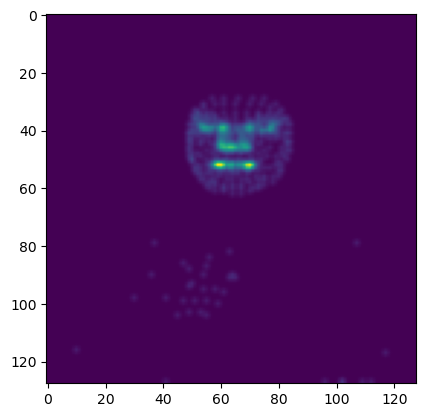

In [213]:
plt.imshow(img); plt.show()

In [214]:
fig, ax = plt.subplots(figsize=(5, 8))

def update(i):
    im_normed = humans[i]
    ax.imshow(im_normed)
    ax.set_title(f"human_{i}", fontsize=20)
    ax.set_axis_off()


anim = FuncAnimation(fig, update, frames=np.arange(0, len(frames)), interval=10)
anim.save('human.gif', dpi=80, writer='imagemagick')
plt.close()

MovieWriter imagemagick unavailable; using Pillow instead.


In [159]:
# pose_x = f0_pose[:,:1]
# pose_y = f0_pose[:,1:2]

# pose_x = (pose_x-np.min(pose_x))/(np.max(pose_x)-np.min(pose_x))
# pose_y = (pose_y-np.min(pose_y))/(np.max(pose_y)-np.min(pose_y))

# pose = np.squeeze(np.array(list(zip(pose_x, pose_y))), axis=-1)

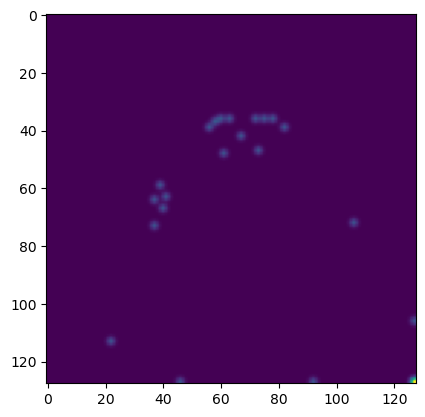

In [158]:
img = points_to_gaussian_heatmap(f0_pose[:,:2], H, W, SCALE)

plt.imshow(img); plt.show()

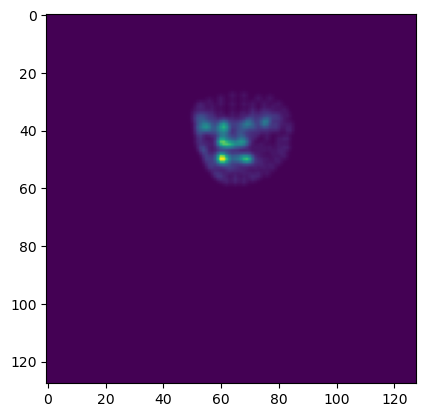

In [143]:
img = points_to_gaussian_heatmap(f0_face[:,:2], H, W, SCALE)

plt.imshow(img); plt.show()

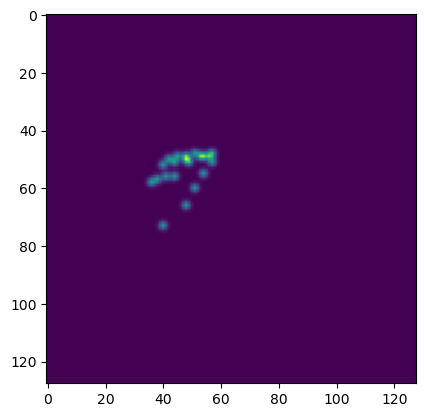

In [144]:
img = points_to_gaussian_heatmap(f0_rh[:,:2], H, W, SCALE)

plt.imshow(img); plt.show()

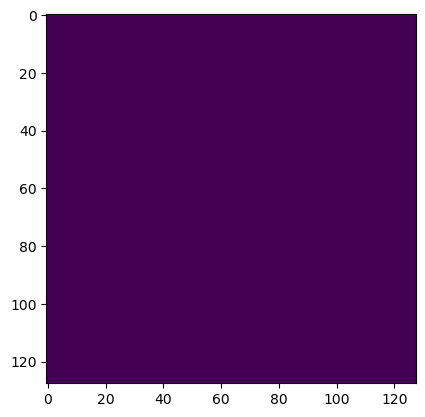

In [145]:
img = points_to_gaussian_heatmap(f0_lh[:,:2], H, W, SCALE)

plt.imshow(img); plt.show()